# CAB420 Assignment 1A Question 1: Template
Simon Denman (s.denman@qut.edu.au)

## Overview

This notebook provides a brief template for CAB420 Assignment 1A, Question 1. It implements the data loading, and splitting the data into the predictors and response. You are to use the data splits defined here in your response.

The template also provides other suggestions around how to approach the problem.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

In [145]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats


from sklearn.linear_model import RidgeCV, LassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [166]:
def display_model_residuals(model: sm.regression.linear_model.RegressionResultsWrapper, model_type: str):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sb.histplot(data=model.resid, kde=True, ax=axes[0])
    axes[0].set_title(f"{model_type} Histogram")

    qq = stats.probplot(model.resid, dist="norm")
    theoretical_quantiles = qq[0][0]
    sample_quantiles = qq[0][1] 
    
    sb.scatterplot(x=theoretical_quantiles, y=sample_quantiles, color='blue', ax=axes[1], label="Residuals")
    sb.lineplot(x=theoretical_quantiles, y=theoretical_quantiles, color='red', linestyle="--", ax=axes[1], label="45-degree line")
    axes[1].set_title(f"{model_type} Q-Q Plot")
    axes[1].legend()

    sb.scatterplot(x=model.fittedvalues, y=model.fittedvalues, color='green', ax=axes[2], label='Fitted Values')
    sb.scatterplot(x=model.fittedvalues, y=model.resid, color='blue', ax=axes[2], label='Residuals')
    axes[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual')
    axes[2].set_title(f"{model_type} Scatter Plot")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def display_model_results(model_ols: sm.regression.linear_model.RegressionResultsWrapper, model_type: str):
    print("\n")
    print(model_type)
    print("R²:", model_ols.rsquared)
    print("Adjusted R²:", model_ols.rsquared_adj)
    print("AIC:", model_ols.aic)
    print("BIC:", model_ols.bic)

def display_rmse_and_predictions(model_ols, x_train, y_train, x_val, y_val, model_type):
    y_pred = model_ols.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)) 

    print(f'{model_type} root mean squared error (rmse): {rmse}')
    
    #predictions_df = pd.DataFrame({'actual': y_val, 'predicted': y_pred})
    
    sb.set_style("whitegrid")

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].set_title(f"{model_type} - Distribution of Actual vs. Predicted Values")
    sb.histplot(y_val, label="Actual", kde=True, color="blue", alpha=0.5, ax=axs[0])
    sb.histplot(y_pred, label="Predicted", kde=True, color="red", alpha=0.5, ax=axs[0])
    axs[0].legend()

    axs[1].set_title(f"{model_type} - Actual vs. Predicted")
    sb.scatterplot(x=y_val, y=y_pred, ax=axs[1])
    axs[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red", linestyle="--")  
    axs[1].set_xlabel("Actual Values")
    axs[1].set_ylabel("Predicted Values")

    residuals = y_val - y_pred
    
    axs[2].set_title(f"{model_type} - Residual Plot")
    sb.residplot(x=y_pred, y=residuals, lowess=True, line_kws={"color": "red"}, ax=axs[2])
    axs[2].set_xlabel("Predicted Values")
    axs[2].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

def display_lasso_ridge_performance(model, X_train, y_train, X_val, y_val, model_name):
    """
    Display RMSE, predictions, and residuals for Lasso and Ridge models.
    
    model: Trained Lasso or Ridge model.
    X_train, y_train: Training data.
    X_val, y_val: Validation data.
    model_name: String name of the model ("Lasso" or "Ridge").
    """
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred)) 

    print(f'{model_name} Root Mean Squared Error (RMSE): {rmse:.4f}')
    
    sb.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].set_title(f"{model_name} - Distribution of Actual vs. Predicted Values")
    sb.histplot(y_val, label="Actual", kde=True, color="blue", alpha=0.5, ax=axs[0])
    sb.histplot(y_pred, label="Predicted", kde=True, color="red", alpha=0.5, ax=axs[0])
    axs[0].legend()

    axs[1].set_title(f"{model_name} - Actual vs. Predicted")
    sb.scatterplot(x=y_val, y=y_pred, ax=axs[1])
    axs[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red", linestyle="--")  
    axs[1].set_xlabel("Actual Values")
    axs[1].set_ylabel("Predicted Values")

    residuals = y_val - y_pred
    axs[2].set_title(f"{model_name} - Residual Plot")
    sb.residplot(x=y_pred, y=residuals, lowess=True, line_kws={"color": "red"}, ax=axs[2])
    axs[2].set_xlabel("Predicted Values")
    axs[2].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

In [5]:
# load data
train = pd.read_csv('./Data/Q1/communities_train.csv')
val = pd.read_csv('./Data/Q1/communities_val.csv')
test = pd.read_csv('./Data/Q1/communities_test.csv')

# Pull out X and y components of the data
# if you want to convert this data to numpy format, you can add .to_numpy() to the end of each row below
X_train = train.iloc[:, 0:-1].to_numpy()
y_train = train.iloc[:, -1].to_numpy()

X_val = val.iloc[:, 0:-1].to_numpy()
y_val = val.iloc[:, -1].to_numpy()

X_test = test.iloc[:, 0:-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy()

In [6]:
# If you wish to pre-process the data, do so here. In your write-up, outline why you choose to do, or choose not to do, any
# pre-processing
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

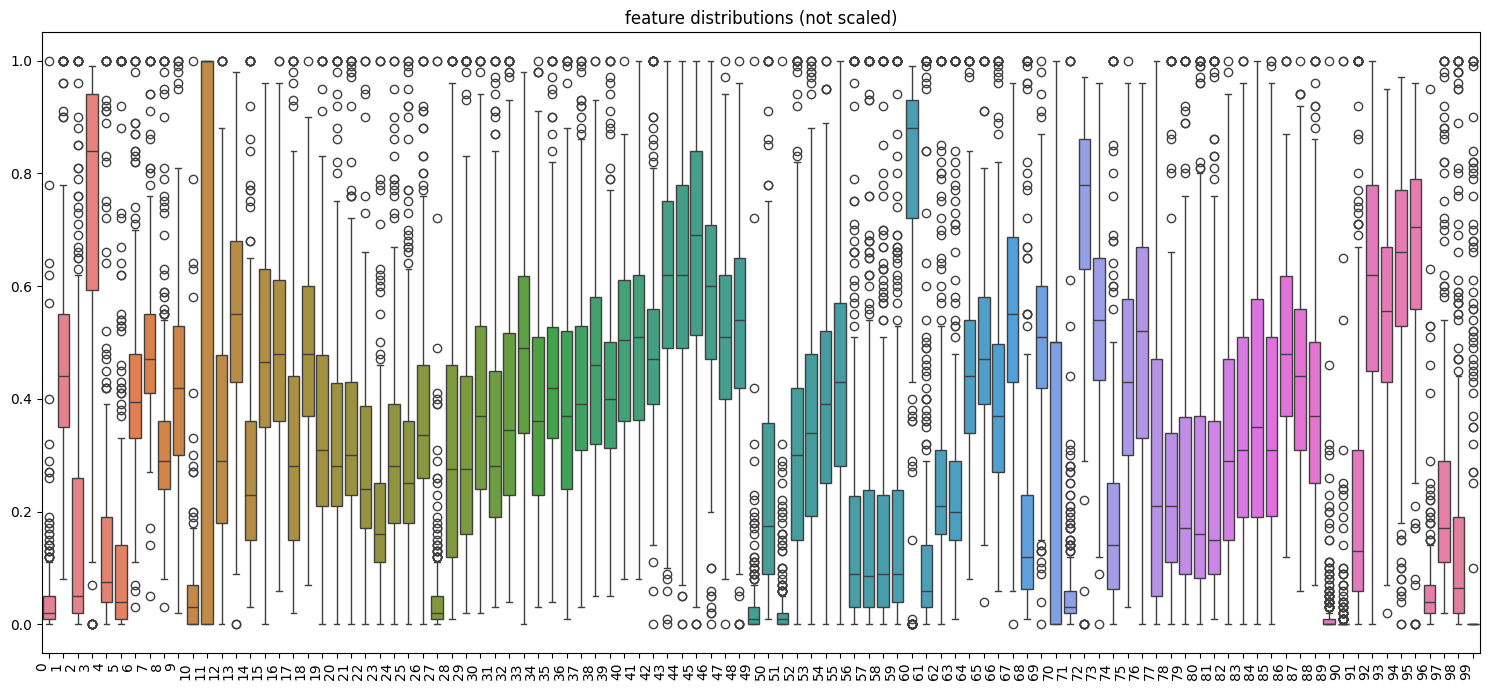

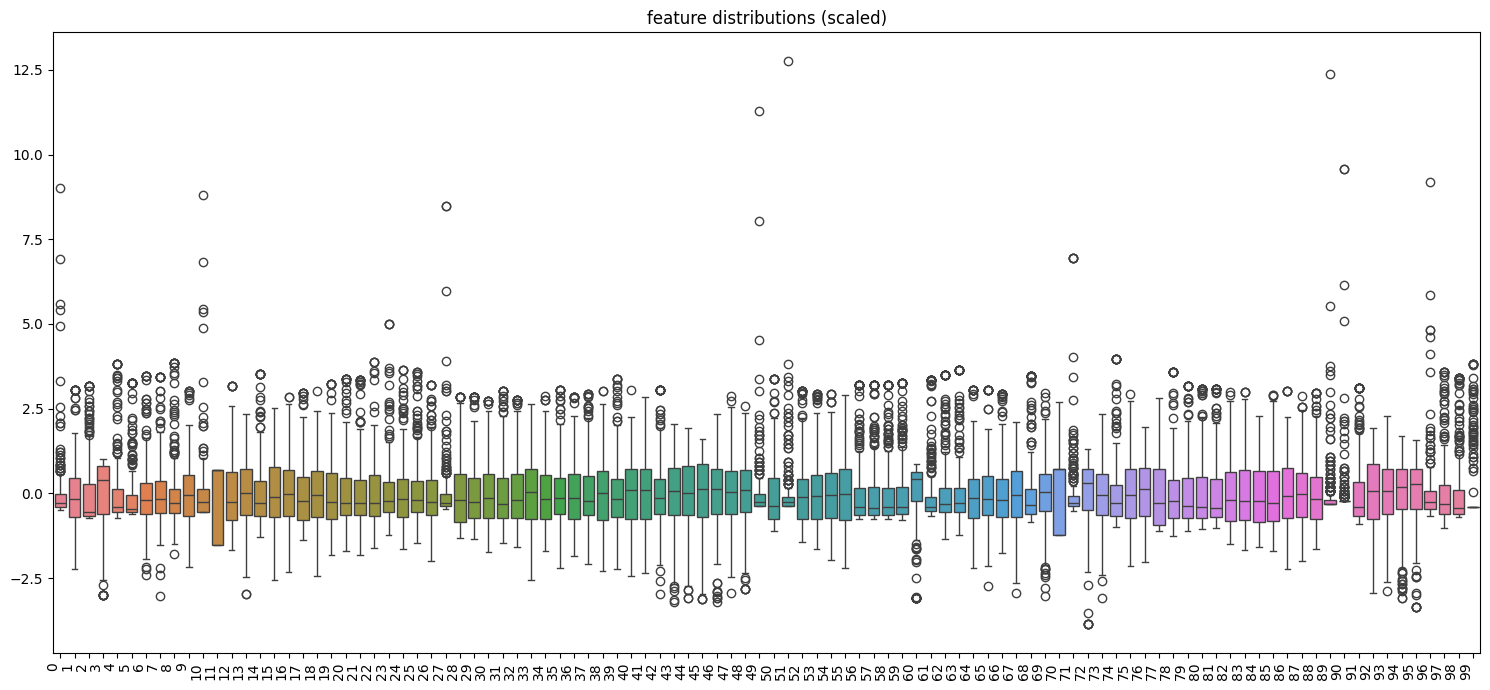

In [7]:
plt.figure(figsize=(15, 7))
sb.boxplot(data=X_train)
plt.title("feature distributions (not scaled)")
plt.xticks(rotation=90, ha="right", fontsize=10)
plt.tight_layout() 
plt.show()

plt.figure(figsize=(15, 7))
sb.boxplot(data=X_train_scaled)
plt.title("feature distributions (scaled)")
plt.xticks(rotation=90, ha="right", fontsize=10)
plt.tight_layout() 
plt.show()

In [16]:
# train your Linear Regression model here. Data has already been split into predictors (X_train, X_val and X_test) and the
# desired response (y_train, y_val and y_test above).
#
# Note that you DO NOT NEED to remove any variables, or add higher order terms. JUST USE THE DATA AS IS.
#
X_train_const = sm.add_constant(X_train)
X_train_const_scaled = sm.add_constant(X_train_scaled)

X_val_const = sm.add_constant(X_val)
X_val_const_scalled = sm.add_constant(X_val_scaled)

model_ols = sm.OLS(y_train, X_train).fit()
model_ols_const = sm.OLS(y_train, X_train_const).fit()
model_ols_const_scaled = sm.OLS(y_train, X_train_const_scaled).fit()
# Once you've trained the model, evaluate it. This would include:
#  - Measuring the accuracy of the model (i.e. RMSE or similar measures)
#  - Looking at the properties of the fitted model, for example the R^2, and if all terms are contributing to the model
#  - Considering the validity of the trained model. This could include assumptions about independent predictors, and the 
#    distribution of the residuals
# Your write-up should include your findings regarding the above.

In [17]:
print(X_train_const.shape)
print(X_val_const.shape)

(298, 101)
(298, 101)


In [18]:
display_model_results(model_ols, "OLS")
display_model_results(model_ols_const, "OLS")
display_model_results(model_ols_const_scaled, "OLS (Scaled)")



OLS
R²: 0.8898290191931328
Adjusted R²: 0.8341871096947151
AIC: -301.2764106357273
BIC: 68.4329380148132


OLS
R²: 0.759085121509442
Adjusted R²: 0.6367933050167729
AIC: -300.133317607413
BIC: 73.27312452963281


OLS (Scaled)
R²: 0.7590851215094419
Adjusted R²: 0.6367933050167727
AIC: -300.133317607413
BIC: 73.27312452963281


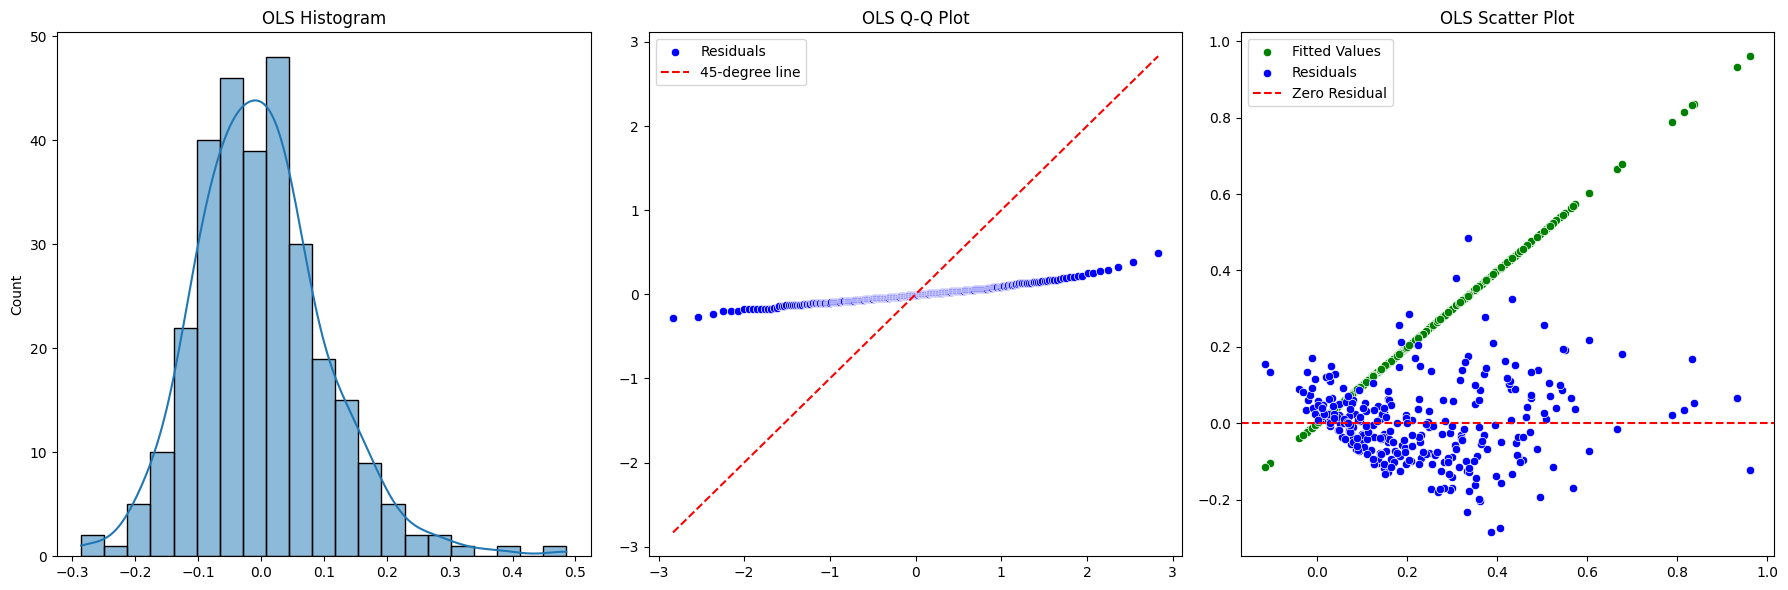

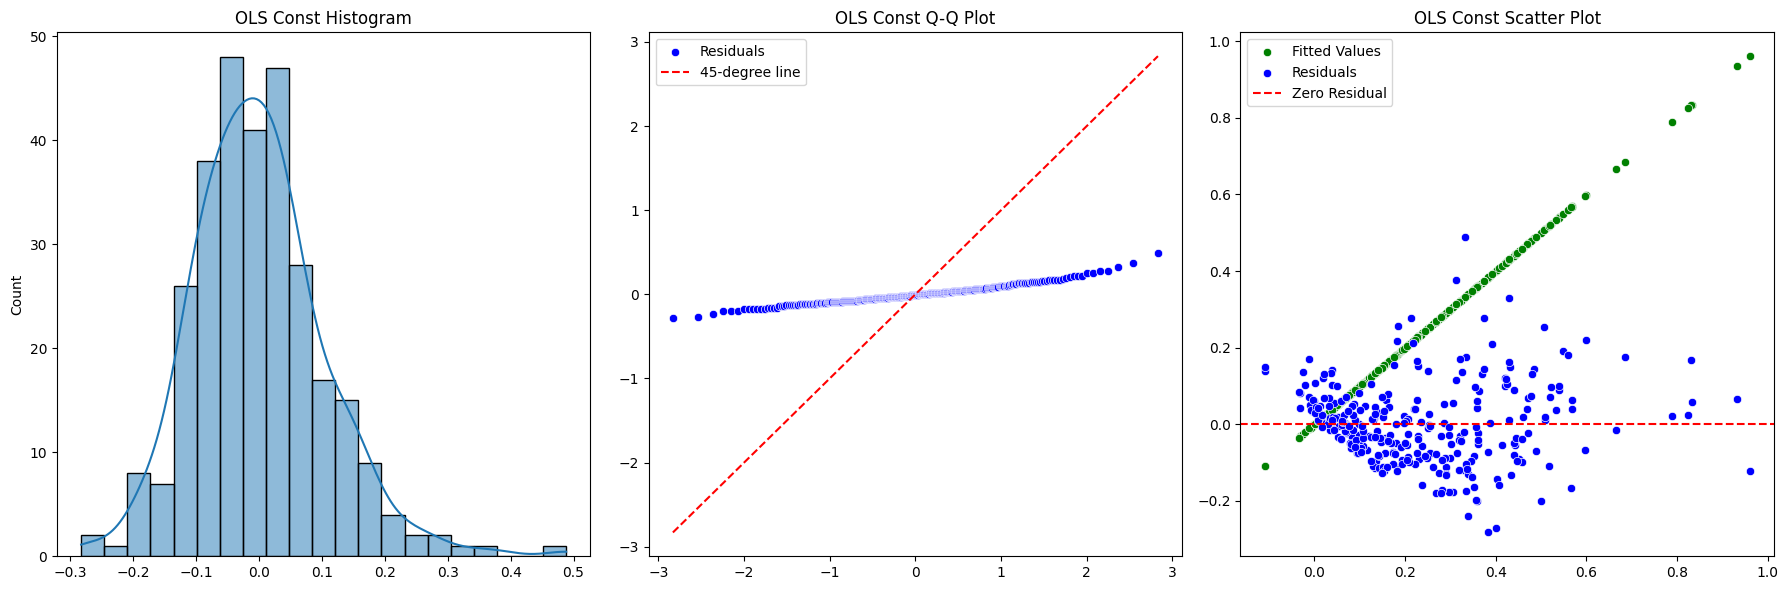

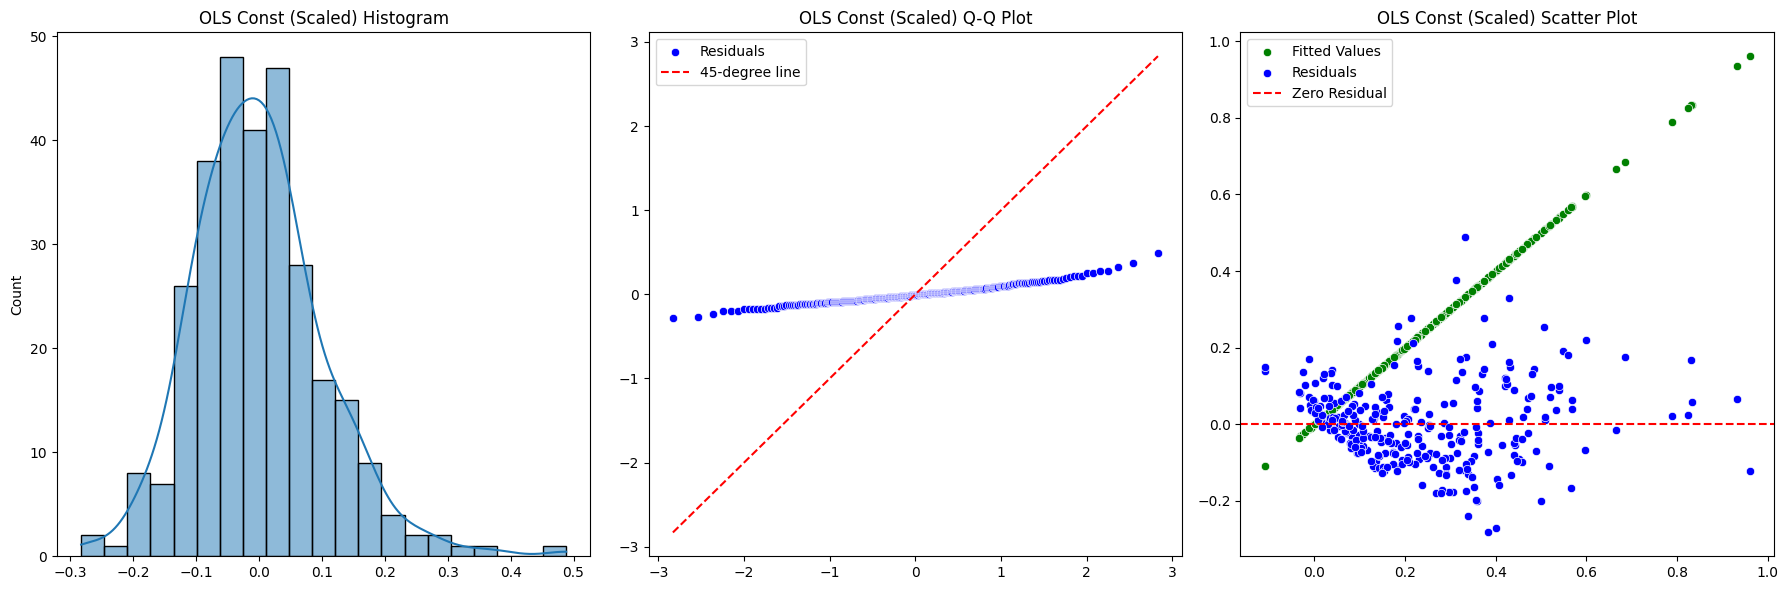

In [22]:
display_model_residuals(model_ols, "OLS")
display_model_residuals(model_ols_const, "OLS Const")
display_model_residuals(model_ols_const_scaled, "OLS Const (Scaled)")

In [23]:
shapiro_test = stats.shapiro(model_ols.resid)

print("Shapiro-Wilk test:", shapiro_test)
print("Skewness:", stats.skew(model_ols.resid))
print("Kurtosis:", stats.kurtosis(model_ols.resid))

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.9725925451243033), pvalue=np.float64(1.8390353741543888e-05))
Skewness: 0.6964410182811946
Kurtosis: 1.8340160592095671


OLS root mean squared error (rmse): 0.15559823663564654


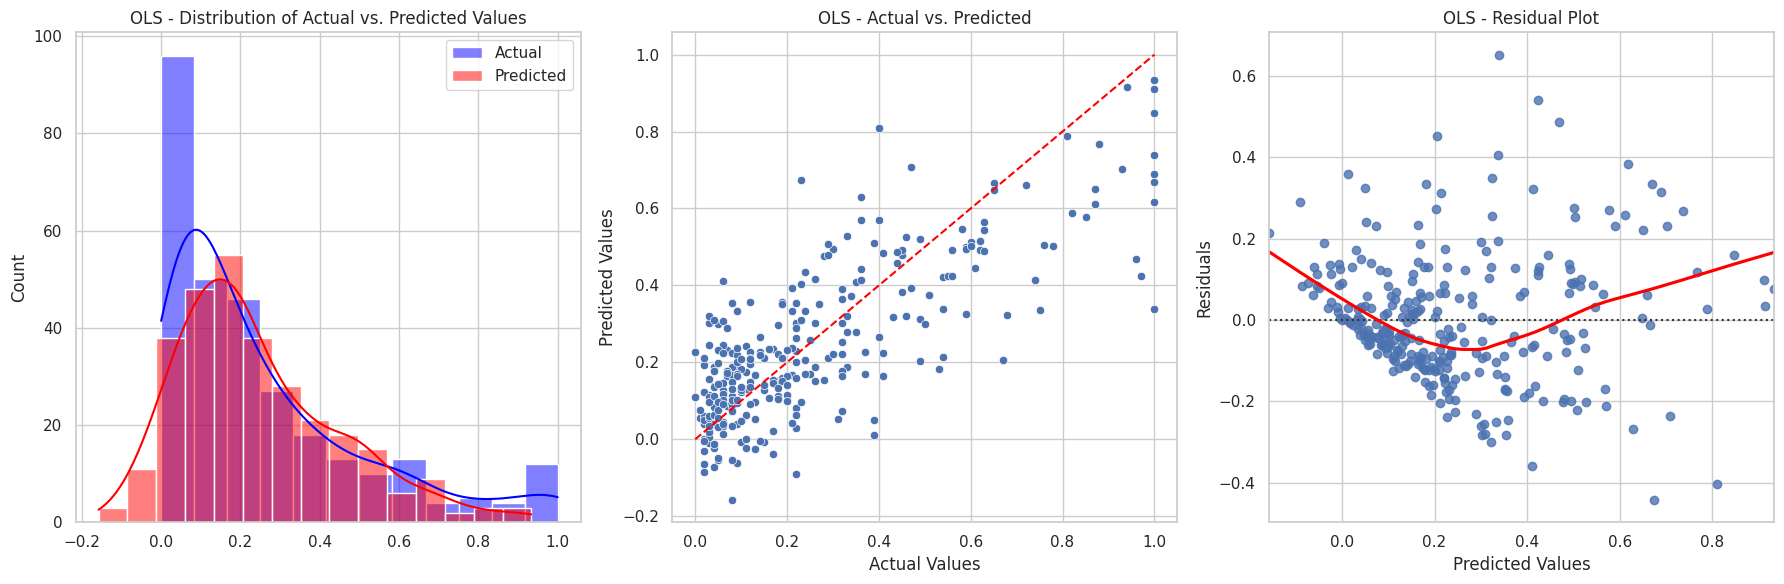

OLS Const root mean squared error (rmse): 0.15491210066258204


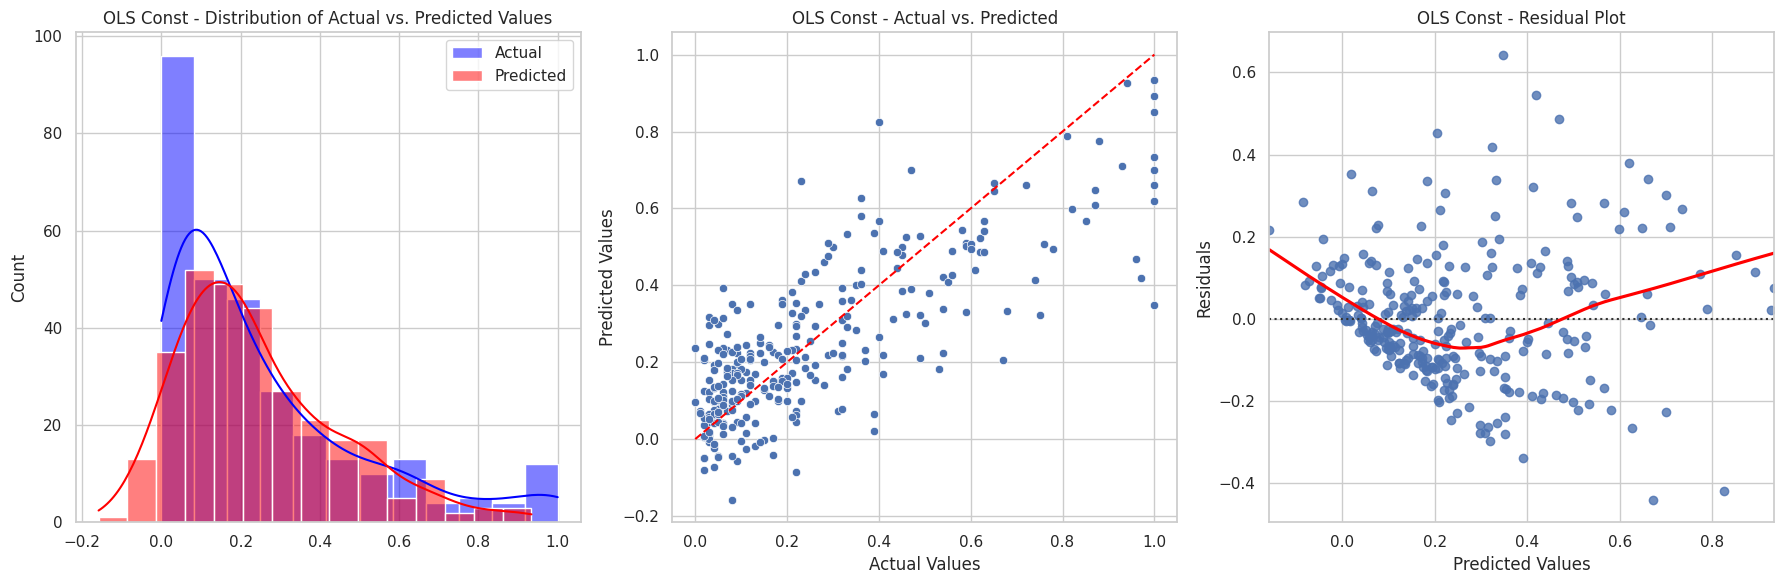

OLS Const scaled root mean squared error (rmse): 0.23468493533727317


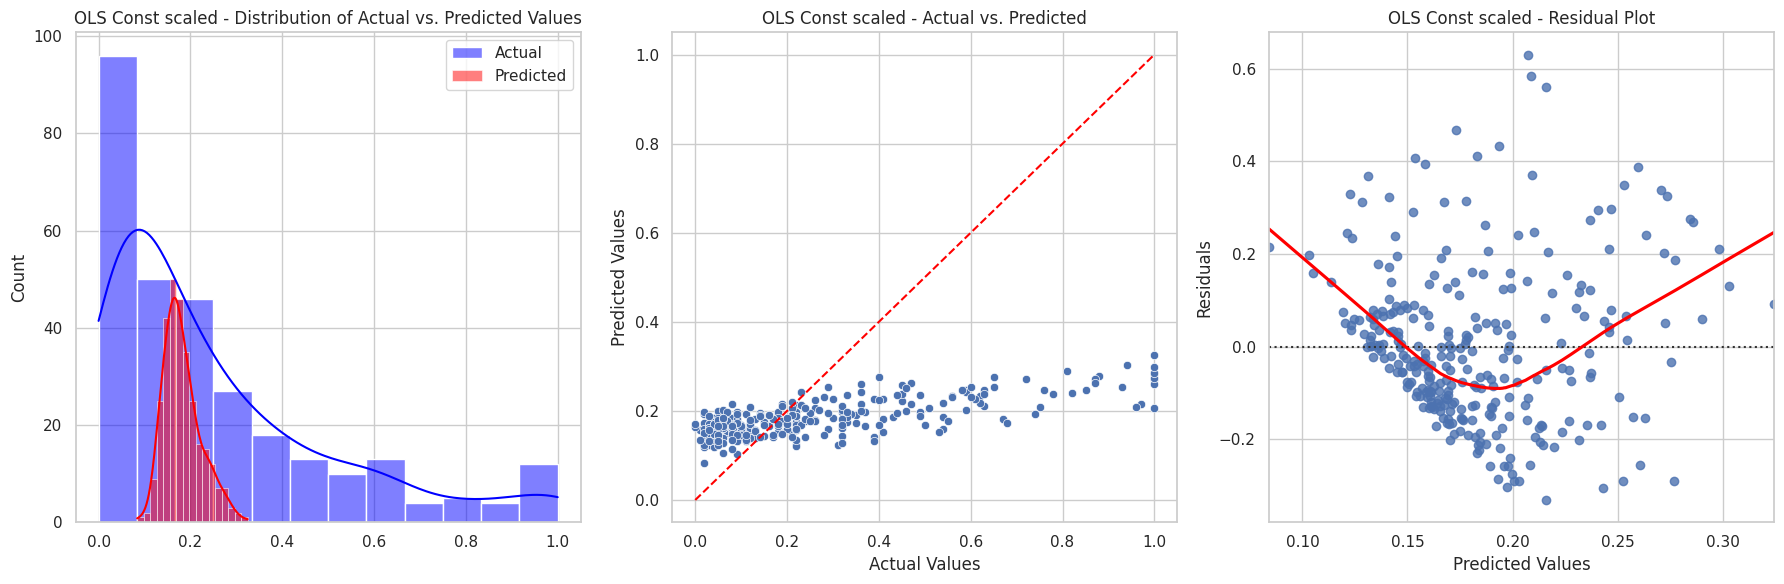

In [133]:
display_rmse_and_predictions(model_ols=model_ols, x_train=X_train, x_val=X_val, y_train=y_train, y_val=y_val, model_type="OLS")
display_rmse_and_predictions(model_ols=model_ols_const, x_train=X_train_const, x_val=X_val_const, y_train=y_train, y_val=y_val, model_type="OLS Const")
display_rmse_and_predictions(model_ols=model_ols_const_scaled, x_train=X_train_const, x_val=X_val_const, y_train=y_train, y_val=y_val, model_type="OLS Const scaled")

In [168]:
# train your regularised models (ridge and lasso). Here you will use the same data as you used in for the above regression model
#
# One key consideration with your regularised models is the selection of lambda (i.e. the strength of the regularisation). A suggested 
# starting point for finding your value of lambda is suggested below using numpy.logspace (see 
# https://numpy.org/doc/stable/reference/generated/numpy.logspace.html). The code below will give you 50 values starting at 10-10 and 
# finishing at 1, spread on a log scale. Just note that for plotting things that result from this, you may want to change the scale of 
# your x-axis to a log scale (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html)
#
# Note that the below list of lambda is going to be fairly coarse. For the sake of speed, we suggest that you avoid evaluating a huge
# number of lambdas in one pass, but you can get a more precise estimate by refining your estimate over multiple passes (i.e. if your
# initial estimate if 0.1, you could run the search again now looking over a range of [0.01 .. 1.0] or similar). If you wish to do this,
# we suggest limiting yourself to 2-3 passes at most. You do not need to get the perfect value of lambda.
#
# remember that lambda is a keyword in python, so we're calling the array below alphas. 
#
alphas = np.logspace(-10, 0)
#alphas = np.logspace(-6, 0, 100)

ridge_model = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_model.fit(X_train, y_train)

ridge_model_scaled = RidgeCV(alphas=alphas, store_cv_results=True)
ridge_model_scaled.fit(X_train_scaled, y_train)

lasso_model = LassoCV(alphas=alphas, cv=5, max_iter=20000)
lasso_model.fit(X_train, y_train)

lasso_model_scaled = LassoCV(alphas=alphas, cv=5, max_iter=20000)
lasso_model_scaled.fit(X_train_scaled, y_train)

param_grid = {'alpha': np.logspace(-6, 0, 100)}

grid_search = GridSearchCV(Lasso(max_iter=20000), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_alpha_grid = grid_search.best_params_['alpha']

print(f"Best alpha from GridSearchCV: {best_alpha_grid}")

Best alpha from GridSearchCV: 0.004328761281083062


In [169]:
# Once you've found your ridge and lasso models, evaluate them, following the approach you've used for the linear method, and compare the
# three models.

In [170]:
print(ridge_model.alpha_)
print(ridge_model.intercept_)
print(ridge_model.score(X_test, y_test))

1.0
0.44020434869601444
0.6813709178421645


Lasso Scaled (val) Root Mean Squared Error (RMSE): 0.1454


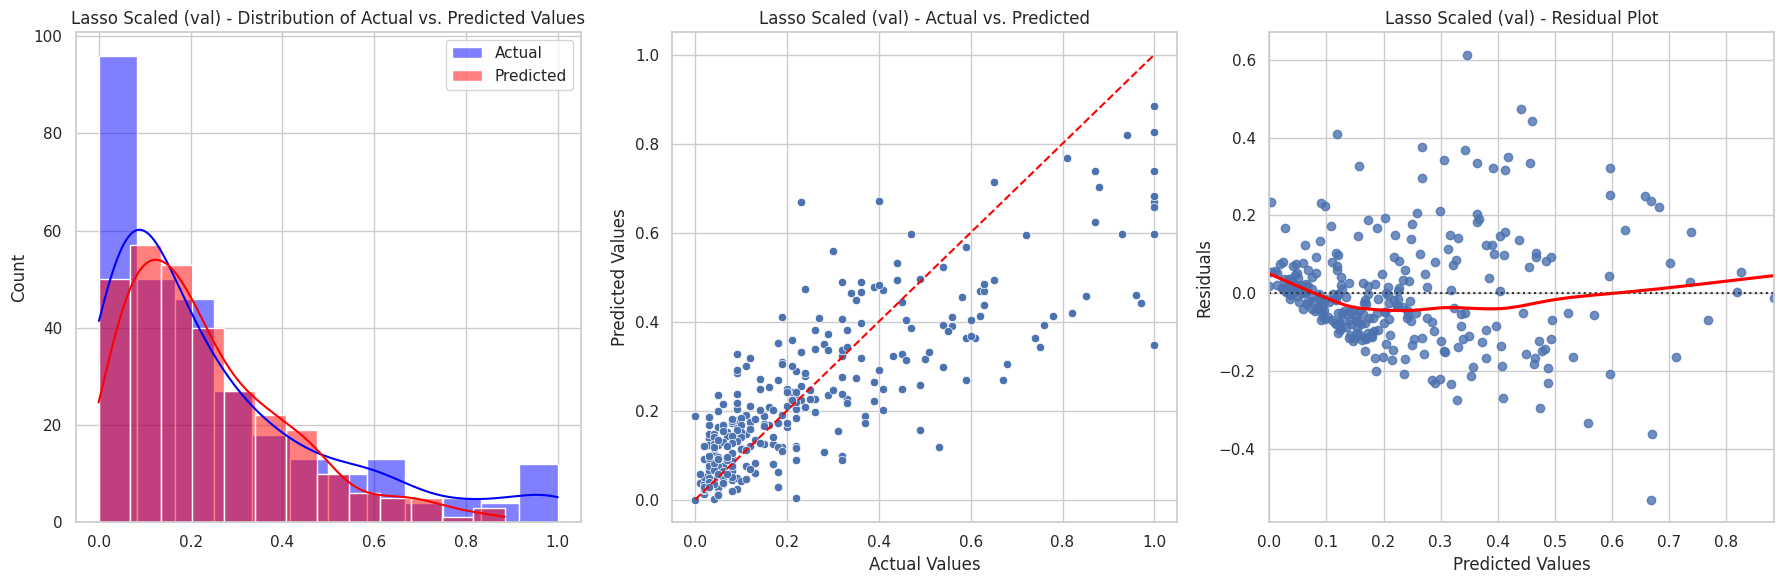

Ridge Scaled (val) Root Mean Squared Error (RMSE): 0.1461


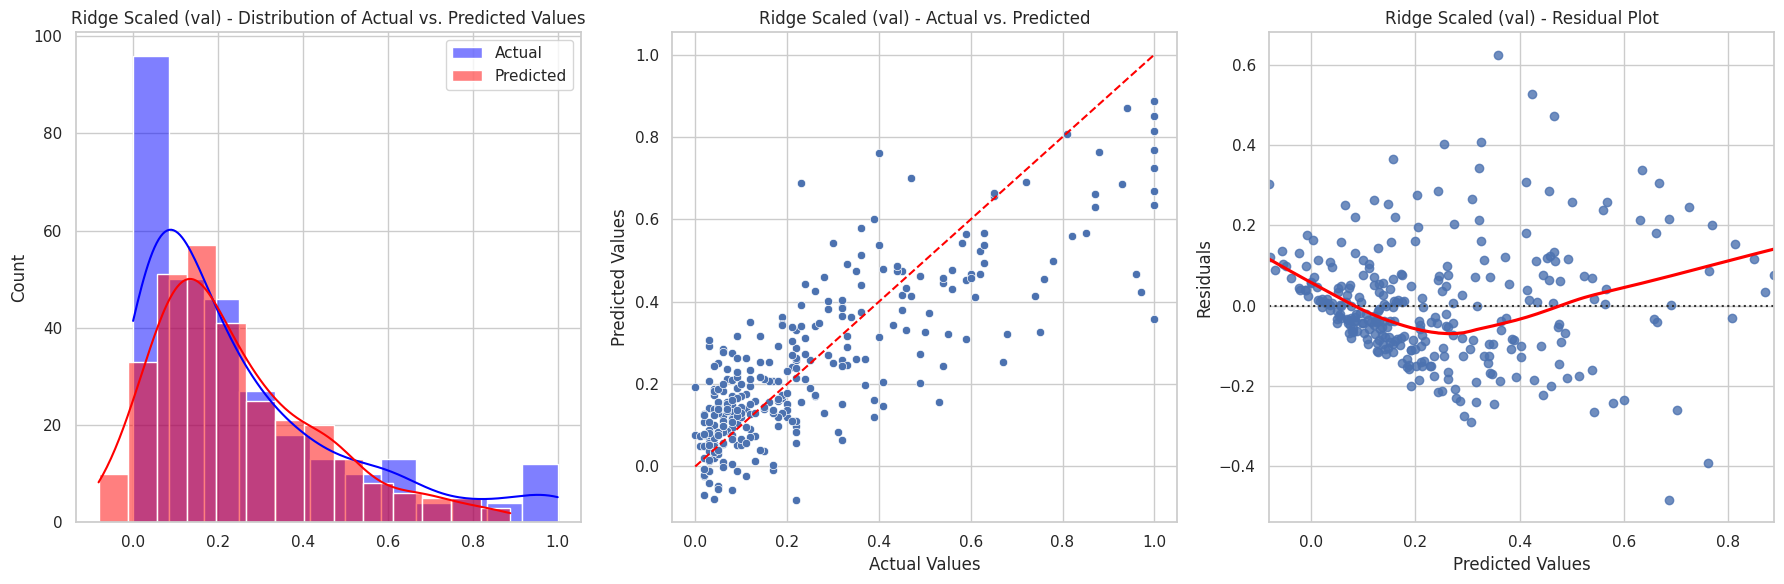

In [174]:
display_lasso_ridge_performance(lasso_model_scaled, X_train_scaled, y_train, X_val_scaled, y_val, "Lasso Scaled (val)")
display_lasso_ridge_performance(ridge_model_scaled, X_train_scaled, y_train, X_val_scaled, y_val, "Ridge Scaled (val)")

Lasso (test) Root Mean Squared Error (RMSE): 0.7026


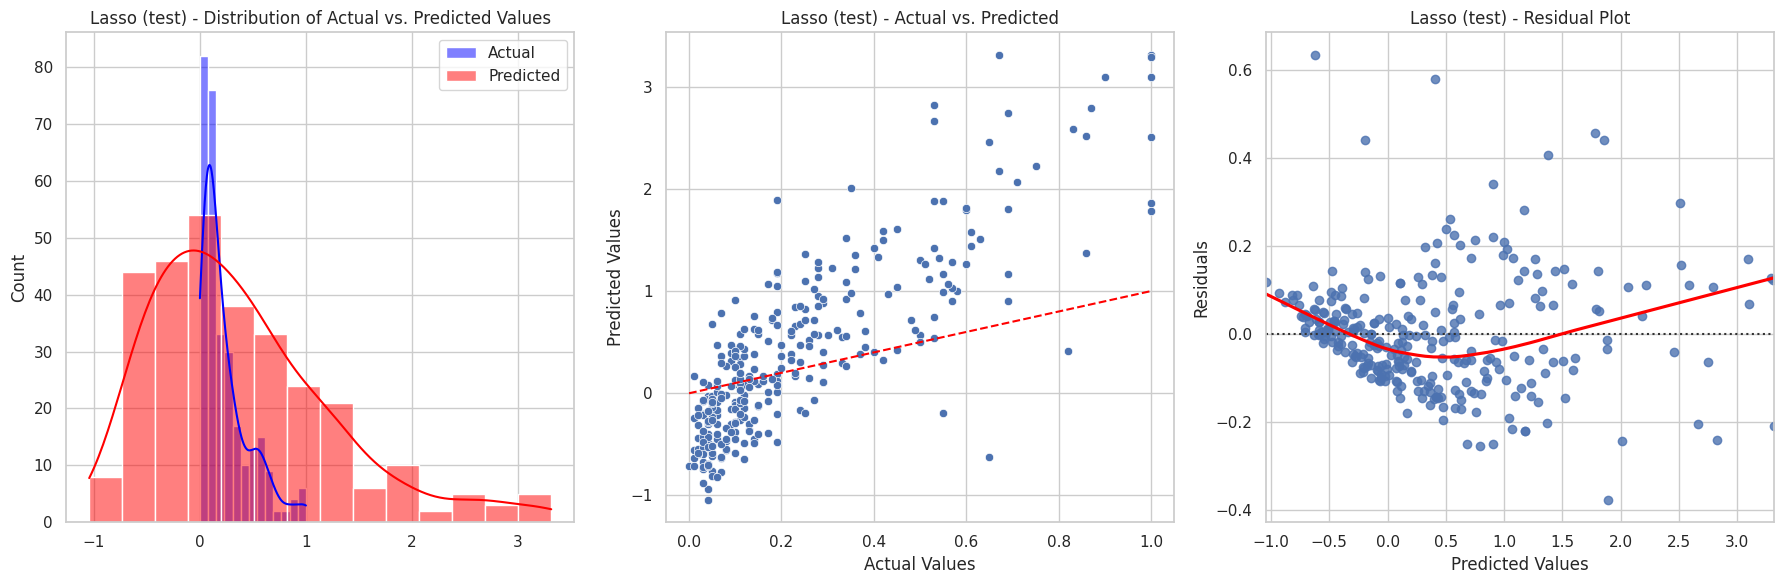

Ridge (test) Root Mean Squared Error (RMSE): 0.7973


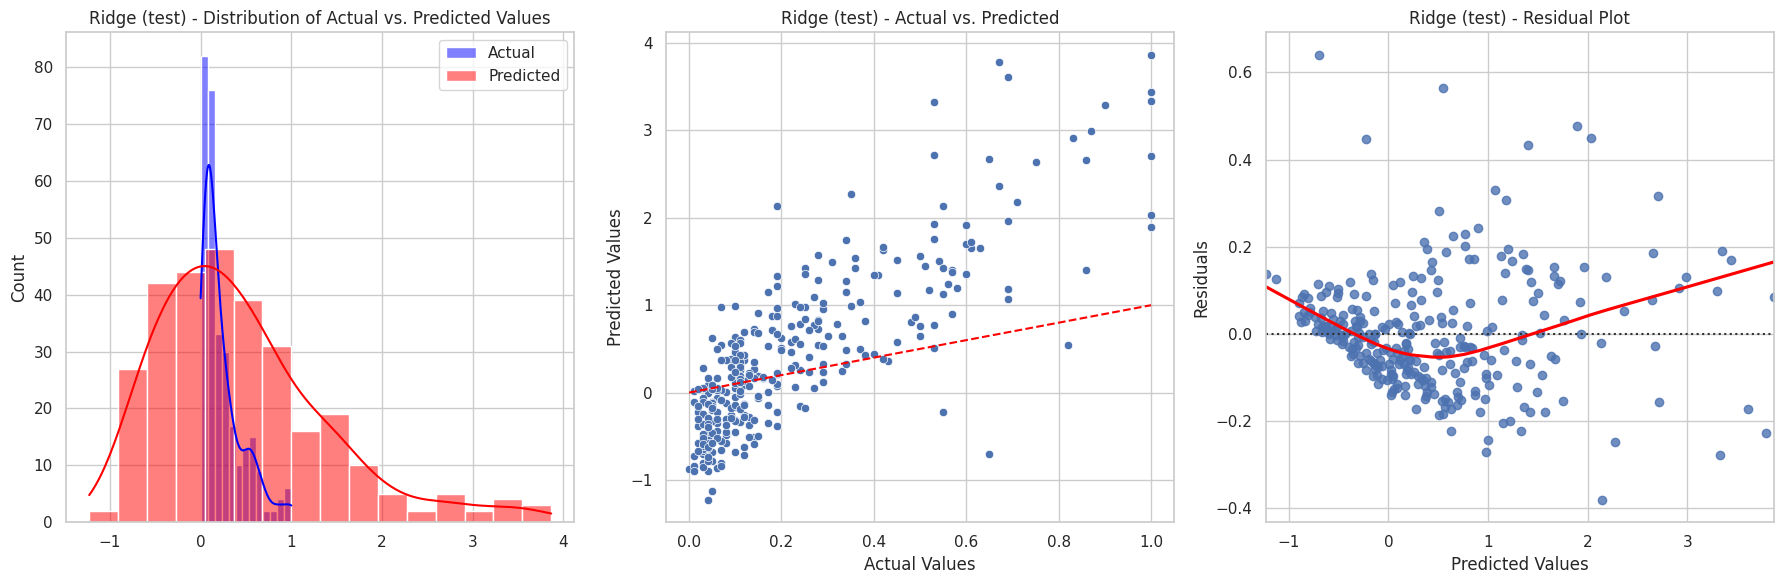

In [173]:
display_lasso_ridge_performance(lasso_model_scaled, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Scaled (test)")
display_lasso_ridge_performance(ridge_model_scaled, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Scaled (test)")

In [165]:
# For your write-up, you should include:
# - a discussion of any pre-processing you did and why; or why you left the data as-is
# - a discussion of how you selected the values of lambda used in your regularised models, and what those values are
# - a comparison of three models, considering both the accuracy and validity of the models, as outlined above, this means:
#   > accuracy of the model
#   > measures of fit, such as R^2
#   > testing assumptions about the independence of predictors, and the distribution of the residuals
# - A discussion of the ethical concerns that need to be considered when evaluating the models developed for this problem
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions. 
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT